In [1]:
#Import Modules
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

data  =  pd.read_csv("appl.csv")
data["Date"]=pd.to_datetime(data.Date)

In [2]:
#Formatting Data w/out $$

data["Open"] = data["Open"].str.replace("\$", "",regex = True).astype(float)
data["High"] = data["High"].str.replace("\$", "",regex = True).astype(float)
data["Close/Last"] = data["Close/Last"].str.replace("\$", "",regex = True).astype(float)
data["Low"] = data["Low"].str.replace("\$", "",regex = True).astype(float)

#Formatting Columns

data.rename(columns= {" Close/Last" : "Close/Last", " Volume" : "Volume",
 " Open" : "Open", " High" : "High", " Low" : "Low"}, inplace = True) 


In [3]:
#Split into train and test:
data_to_train = data[:1000]
data_to_test = data[1000:]

data_to_train.to_csv("train_data.csv")
data_to_test.to_csv("test_data.csv")


print(data.head())

        Date  Close/Last    Volume    Open     High     Low
0 2021-05-21      125.43  79295440  127.82  128.000  125.21
1 2021-05-20      127.31  76857120  125.23  127.720  125.10
2 2021-05-19      124.69  92611990  123.16  124.915  122.86
3 2021-05-18      124.85  63342930  126.56  126.990  124.78
4 2021-05-17      126.27  74116550  126.82  126.930  125.17


In [4]:
#model
training_set = data_to_train.iloc[:, 3:4].values
real_stock_price = data_to_test.iloc[:, 3:4].values

sc = MinMaxScaler(feature_range=(0, 1))
training_data_scaled = sc.fit_transform(training_set)
# The fit method is calculating the mean and variance of each of the features present in our data. The transform method is transforming all the features using the respective mean and variance. Now, we want scaling to be applied to our test data too and at the same time do not want to be biased with our model

X_train = []
y_train = []
for i in range(60, 1000):
    X_train.append(training_data_scaled[i - 60:i, 0])
    y_train.append(training_data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [5]:
# Building Model:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True,
                              input_shape=(X_train.shape[1],1)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=1))
model.summary()
#We use Dropout layers to avoid Overfitting problems, and besides that, we use the parameter “return_sequences” to determine if the layer will return a sequence compatible with a LSTM. We use “return_sequences=True” when we have a LSTM layer after!

model.compile("Adam", "MSE")
modelo = model.fit(X_train, y_train, epochs=100, batch_size=32)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

30/30 [==============================] - 2s 81ms/step - loss: 0.0013
Epoch 83/100
30/30 [==============================] - 2s 79ms/step - loss: 0.0016
Epoch 84/100
30/30 [==============================] - 2s 82ms/step - loss: 0.0014
Epoch 85/100
30/30 [==============================] - 2s 83ms/step - loss: 0.0014
Epoch 86/100
30/30 [==============================] - 2s 79ms/step - loss: 0.0013
Epoch 87/100
30/30 [==============================] - 2s 79ms/step - loss: 0.0015
Epoch 88/100
30/30 [==============================] - 2s 81ms/step - loss: 0.0013
Epoch 89/100
30/30 [==============================] - 3s 85ms/step - loss: 0.0013
Epoch 90/100
30/30 [==============================] - 3s 86ms/step - loss: 0.0013
Epoch 91/100
30/30 [==============================] - 3s 85ms/step - loss: 0.0016
Epoch 92/100
30/30 [==============================] - 2s 79ms/step - loss: 0.0014
Epoch 93/100
30/30 [==============================] - 2s 79ms/step - loss: 0.0014
Epoch 94/100
30/30 [=========

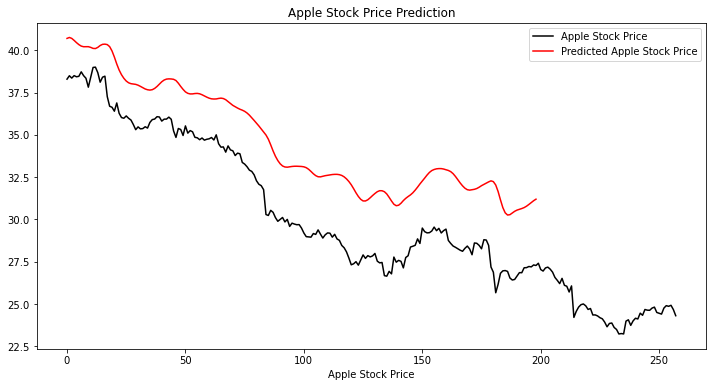

In [6]:
####################Predict
dataset_total = pd.concat([data_to_train["Open"], data_to_test["Open"]], axis=0)
inputs = dataset_total[len(dataset_total) - len(data_to_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 259):
   X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

plt.figure(figsize=(12, 6))

plt.plot(real_stock_price, color='black', label='Apple Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Apple Stock Price')

plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.xlabel('Apple Stock Price')
plt.legend()
plt.show()